In [2]:
try:
    import mesa
except ImportError:
    !pip install mesa
    import mesa

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Resource Classes

In [3]:
class Sugar(mesa.Agent):

    def __init__(self, model, pos, max_sugar):
        super().__init__(model)
        self.amount = max_sugar
        self.max_sugar = max_sugar





In [4]:
class Spice(mesa.Agent):

    def __init__(self, model, pos, max_spice):
        super().__init__(model)
        self.amount = max_spice
        self.max_spice = max_spice



In [14]:
class Trader(mesa.Agent):
    def __init__(self, model, pos, moore=False, sugar=0, spice=0, metabolism_sugar=0, metabolism_spice=0, vision=0):

        super().__init__(model)
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision




# model class

In [12]:
class SugarscapeG1mt(mesa.Model):
    def __init__(self, width=50, height=50, initial_population=200,
                 endowment_min=20, endowment_max=50,
                 metabolism_min=1, metabolism_max=5,
                 vision_min=1, vision_max=5):
        
        # 부모 클래스(mesa.Model) 초기화
        super().__init__()


        self.width = width
        self.height = height

        # Initialize
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max


        # torus=True로 하면 팩맨처럼 맵이 연결됩니다.
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)

        self.sugar_distribution = np.genfromtxt("sugar-map.txt")
        self.spice_distribution = np.flip(self.sugar_distribution, axis=0)

        # 도화지를 가로로 길게(12x6 크기) 준비합니다.
        plt.figure(figsize=(12, 6))

        # 첫 번째 그림: 설탕 지도 (1행 2열 중 1번째)
        plt.subplot(1, 2, 1)
        plt.imshow(self.sugar_distribution, origin="lower", cmap="Oranges")
        plt.title("Sugar Map")
        plt.colorbar()

        # 두 번째 그림: 향신료 지도 (1행 2열 중 2번째)
        plt.subplot(1, 2, 2)
        plt.imshow(self.spice_distribution, origin="lower", cmap="BuPu")
        plt.title("Spice Map")
        plt.colorbar()


        for _, (x, y) in self.grid.coord_iter():
            max_sugar = self.sugar_distribution[x, y]
            if max_sugar > 0:
                sugar = Sugar(self, (x,y), max_sugar)
                self.grid.place_agent(sugar, (x, y))

            max_spice = self.spice_distribution[x, y]
            if max_spice > 0:
                spice = Spice(self, (x,y), max_spice)
                self.grid.place_agent(spice, (x, y))

        for i in range(self.initial_population):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)

            sugar = self.random.randrange(self.endowment_min, self.endowment_max + 1)
            spice = self.random.randrange(self.endowment_min, self.endowment_max + 1)

            metabolism_sugar = self.random.randrange(self.metabolism_min, self.metabolism_max + 1)
            metabolism_spice = self.random.randrange(self.metabolism_min, self.metabolism_max + 1)

            vision = self.random.randrange(self.vision_min, self.vision_max + 1)

            # Initiate individual agent
            trader = Trader(self, (x,y), moore=False, # moore는 키워드 인자로 유지
                        sugar=sugar, spice=spice, # 나머지 인자들도 키워드 인자로 명시
                        metabolism_sugar=metabolism_sugar, metabolism_spice=metabolism_spice,
                        vision=vision)
            # Place agent
            self.grid.place_agent(trader, (x,y))
            # self.schedule.add(trader) # Mesa 3.0+에서는 필요 없으므로 삭제
            print(trader.unique_id, trader.pos, trader.sugar, trader.spice, trader.metabolism_sugar,trader.metabolism_spice, trader.vision)



# Run Model


4139 (27, 10) 21 44 4 2 1
4140 (3, 38) 24 27 3 5 5
4141 (34, 5) 39 42 2 5 5
4142 (12, 25) 48 29 4 2 2
4143 (35, 11) 50 32 3 5 4
4144 (9, 46) 30 20 4 4 1
4145 (13, 30) 25 22 1 5 4
4146 (46, 20) 44 25 1 4 3
4147 (49, 46) 49 29 1 2 5
4148 (29, 6) 35 41 2 4 3
4149 (32, 30) 47 34 1 4 5
4150 (5, 41) 30 39 3 2 2
4151 (33, 26) 39 49 5 4 2
4152 (12, 28) 39 26 2 3 4
4153 (17, 8) 36 37 4 3 4
4154 (16, 35) 34 28 3 4 4
4155 (35, 42) 31 40 2 4 3
4156 (44, 33) 38 38 4 4 2
4157 (17, 1) 22 50 2 1 5
4158 (47, 42) 46 34 5 3 1
4159 (45, 41) 42 33 1 3 3
4160 (12, 41) 26 43 4 4 4
4161 (30, 49) 23 45 1 4 3
4162 (32, 39) 22 32 2 5 3
4163 (26, 39) 46 36 3 1 5
4164 (0, 11) 27 38 3 5 3
4165 (46, 22) 30 43 2 4 3
4166 (47, 31) 32 40 4 3 1
4167 (49, 43) 39 43 5 3 1
4168 (42, 28) 36 26 5 2 5
4169 (18, 33) 42 39 2 5 3
4170 (18, 4) 43 43 3 2 3
4171 (11, 26) 49 49 5 5 3
4172 (37, 30) 42 42 5 5 4
4173 (4, 31) 45 34 5 2 1
4174 (37, 48) 28 37 2 5 3
4175 (20, 48) 27 33 2 4 5
4176 (33, 12) 23 23 1 1 2
4177 (44, 3) 26 20 4 4

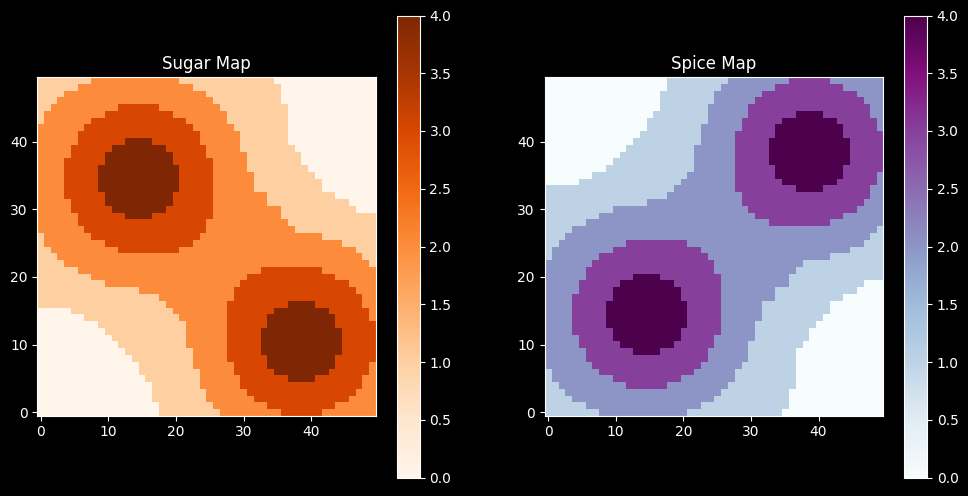

In [15]:
model = SugarscapeG1mt()

In [34]:
print(model.sugar_distribution)
print()

[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
